#Binary Classifier:
Model for determining whether an image is real or fake

# Initial Setup

## Imports

In [0]:
# Importing useful libraries
import math
import os
import random
import torch
import cv2
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torchvision import datasets, models, transforms

from datetime import datetime
from torch.utils.data import DataLoader, Dataset, IterableDataset
from tqdm.auto import tqdm
from tqdm.notebook import tqdm as new_tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms.functional as TF
from google.colab.patches import cv2_imshow
import numpy as np
import copy
import gc #gc is garbage collector.
from scipy.ndimage.filters import gaussian_filter
from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

## Mount Shared Drive

In [2]:
# Mount Shared Drive for project to /content/drive/ folder
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Global Variables

In [3]:
# Torch variables
global_dtype = torch.float32  #Changed on purpose to save memory issues.
global_device = "cuda"
local_device="cpu"
print(f"We will be using global dtype = {global_dtype} and global device = {global_device}")
if torch.cuda.is_available():
  print ("CUDA is available!")

# Image transform variables
image_resize = 224 # Resize all images to be 224 x 224
image_crop = 224 
larger_size= 256
image_rotate = 5 # Rotate images randomly +/- 5 degrees


# The following mean and std are calculated on ImageNet dataset and all pre-trained PyTorch models (like resnet-18)
# expect input images to be normalized using this mean and std values. So we are correct in using these values.
image_mean = torch.tensor([0.485, 0.456, 0.406]) 
image_std= torch.tensor([0.229, 0.224, 0.225]) 

We will be using global dtype = torch.float32 and global device = cuda
CUDA is available!


# Dataset Setup

In [0]:
class data_setup():
  def __init__(self,image_resize,image_crop,image_mean,image_std,b_size,num_workers):
    # Transform the input RGB image:
    # 1) Resize images such that the shorter side is length image_resize and the
    #   other side is a length such that the original aspect ratio is maintained
    # 2) Resize on the center of the image so it is image_resize x image_resize
    # 3) Make it a Tensor

    preprocess = transforms.Compose([transforms.Resize(image_resize),
                                     transforms.CenterCrop(image_resize),
                                     transforms.ToTensor(),
                                     ])


    # By default, all images have pixel intensity values as float numbers between 0 and 1. After normalizing, pixel intensity is in the 
    # range (-2.7) - 2.7. Negative values are undesired. Find relevant mean and std before applying normalization again.
    self.preprocess=preprocess
    self.b_size=b_size
    self.num_workers=num_workers
    self.image_crop=image_crop
    self.image_resize = image_resize
    return
  
  def make_loaders(self,real_roots,fake_roots):
    preprocess=self.preprocess
    b_size=self.b_size
    num_workers=self.num_workers
    
    real_dsets={}
    real_loaders={}
    fake_dsets={}
    fake_loaders={}

    for r in real_roots:  #keys of the real_roots dictionary
      real_dsets[r]=datasets.ImageFolder( root= real_roots[r], transform=preprocess) #.IterableDataset  
      real_loaders[r]=DataLoader(real_dsets[r],  batch_size=b_size, shuffle=True, num_workers= num_workers)  
    
    for r in fake_roots:  #keys of the fake_roots dictionary
      fake_dsets[r]=datasets.ImageFolder( root= fake_roots[r], transform=preprocess) #.IterableDataset  
      fake_loaders[r]=DataLoader(fake_dsets[r],  batch_size=b_size, shuffle=True, num_workers= num_workers)  
    

    return real_dsets,real_loaders,fake_dsets,fake_loaders
    
  def get_items(self,dataset,loader,keep_num,category_label):
    # This function works for given dataset and loader objects. 
    # For iterations over dsets and loaders dictionaries, see the next function.
    b_size=self.b_size
    num_batches = math.ceil(keep_num/b_size)  # Number of batches, last batch would have zeros for the images not filled in.
    cat_list=["real","fake"] #just for use in the next printing statement, no other use.
    print('\n \n New Dataset of type %s: images being loaded = %d, number of batches = %d, \
    batch_size = %d, num_workers = %d'%(cat_list[category_label],keep_num, num_batches,b_size,self.num_workers))
       
    N = keep_num 
    C=3
    H=self.image_resize                              
    W=self.image_resize
    items= torch.zeros((N,C,H,W))
    labels= [0]*N #propagate a list for now.                                                 

    for t,(x,y) in enumerate(loader):
      if t*b_size>=keep_num:
        break
      idx_range=range(t*b_size,min((t+1)*b_size,keep_num))
      idx_slice=slice(t*b_size,min((t+1)*b_size,keep_num))  
      items[idx_range],labels[idx_slice]= x[:len(idx_range)],[category_label]*len(idx_range)

      if t%self.num_workers ==0:
        print("      Downloaded data-batch number = %d, \
              set of image numbers %d - %d "%(t,(t)*b_size, (t+1)*b_size),"labels:", (max(labels[idx_slice])))
              # It has been thoroughly checked, there is no image filled with all zeros - all corner cases and special cases checked.
    labels=torch.Tensor(labels).long()
    return items,labels

  def get_all(self,real_dsets,real_loaders,fake_dsets,fake_loaders,real_num,fake_num):
    real_N=sum(real_num[0:len(real_dsets)])
    fake_N=sum(fake_num[0:len(fake_dsets)])        
    print("Total Real images= ",real_N," Total Fake images= ",fake_N)
    C=3
    H=self.image_resize                            
    W=self.image_resize

    real_images=torch.zeros((real_N,C,H,W),dtype=global_dtype)#device=global_device)
    fake_images=torch.zeros((fake_N,C,H,W),dtype=global_dtype)#device=global_device)
    
    real_labels=torch.zeros((real_N,),dtype=torch.long)#,#device=global_device)
    fake_labels=torch.ones((fake_N,),dtype=torch.long)#,#device=global_device)
    
    print("\n \n Transferring Real Datasets: ")

    start_idx = 0
    for i, k in enumerate(real_dsets):
      idx_range = range(start_idx, start_idx+real_num[i])
      # print(idx_range)
      start_idx += real_num[i]
      
      real_images[idx_range],real_labels[idx_range]=self.get_items(real_dsets[k], real_loaders[k],real_num[i],0) #see that last argument category label =1
      print("     Dataset transferred to tensors, image shape",real_images[idx_range[0]].shape,"label: ",(max(real_labels[idx_range])).item() )

    print("\n \n Transferring Fake Datasets: ")
    
    start_idx = 0
    for i, k in enumerate(fake_dsets):
      idx_range = range(start_idx, start_idx+fake_num[i])
      # print(idx_range)
      start_idx += fake_num[i]
      
      fake_images[idx_range],fake_labels[idx_range]=self.get_items(fake_dsets[k], fake_loaders[k],fake_num[i],1) #see that last argument category label =1
      print("     Dataset transferred to tensors, image shape",fake_images[idx_range[0]].shape,"label: ",(max(fake_labels[idx_range])).item() )
      

    return real_images,real_labels,fake_images,fake_labels

**List of Number of Available Images:**

```
Fouhey -> originals -> real -> 1580
Refined -> Flicker30K -> real -> 2820
Refined -> PS_battles -> real -> 1500
Total Real Images: 5900

Fouhey -> a_0000 -> fake -> 800
Fouhey -> b_0001-> fake -> 800
Fouhey -> c_0002-> fake -> 400
Refined -> PS_battles -> fake -> a_000 -> 500
Refined -> PS_battles -> fake -> z_0011 -> 1800
Refined -> PS_battles -> fake -> z_0012 -> 1600
Total Fake Images: 5900

```
**Data Credits:**
We thank Prof. David Fouhey for his collection of Real and Fake images. We are grateful to Prof. Andrew Owens for making available these datsets and suggestions for other datasets and augmentation techniques.


In [5]:
# Script to run data_setup class:
# Only inputs we need to give are: 
# 1. the root directories: real_roots and fake_roots
# 2. list of number of images to be downloaded: real_num and fake_num

gc.collect() #collect garbage (if it does).
torch.cuda.empty_cache()

b_size=16
num_workers=8
setup=data_setup(image_resize,image_crop,image_mean,image_std,b_size,num_workers)

real_roots={"real_1":"/content/drive/Shared drives/Dataset_504/Fouhey_folders/originals",
            "real_2":"/content/drive/Shared drives/Dataset_504/Refined_Image_sets/Flicker30k_real",
            "real_3":"/content/drive/Shared drives/Dataset_504/Refined_Image_sets/PS_battles_real",
           }
fake_roots={"fake_1":"/content/drive/Shared drives/Dataset_504/Fouhey_folders/a_0000",
            "fake_2":"/content/drive/Shared drives/Dataset_504/Fouhey_folders/b_0001",
            "fake_3":"/content/drive/Shared drives/Dataset_504/Fouhey_folders/c_0002",
            "fake_4":"/content/drive/Shared drives/Dataset_504/Refined_Image_sets/PS_battles_fake/a_0000", 
            "fake_5":"/content/drive/Shared drives/Dataset_504/Refined_Image_sets/PS_battles_fake/z_0011", 
            "fake_6":"/content/drive/Shared drives/Dataset_504/Refined_Image_sets/PS_battles_fake/z_0012",      
           }

real_num=[1580,2820,1500]
fake_num=[800,800,400,500,1800,1600]

real_dsets,real_loaders,fake_dsets,fake_loaders=setup.make_loaders(real_roots,fake_roots)
real_images,real_labels,fake_images,fake_labels= setup.get_all(real_dsets,real_loaders,fake_dsets,fake_loaders,real_num,fake_num)
toy_real=real_images[:512]   # toy data to check model overfitting.
toy_fake=fake_images[:512]   # download at least 512 images of both real and fake types.
toy_real_labels=real_labels[:512]
toy_fake_labels=fake_labels[:512]

#Delete the datasets,dataloaders and free up GPU memory. We only need images and labels stored above.
real_dsets=None
del real_dsets
fake_dsets=None
del fake_dsets

real_loaders=None
del real_loaders
fake_loaders=None
del fake_loaders
gc.collect()
torch.cuda.empty_cache()

Total Real images=  5900  Total Fake images=  5900

 
 Transferring Real Datasets: 

 
 New Dataset of type real: images being loaded = 1580, number of batches = 99,     batch_size = 16, num_workers = 8
      Downloaded data-batch number = 0,               set of image numbers 0 - 16  labels: 0
      Downloaded data-batch number = 8,               set of image numbers 128 - 144  labels: 0
      Downloaded data-batch number = 16,               set of image numbers 256 - 272  labels: 0
      Downloaded data-batch number = 24,               set of image numbers 384 - 400  labels: 0
      Downloaded data-batch number = 32,               set of image numbers 512 - 528  labels: 0
      Downloaded data-batch number = 40,               set of image numbers 640 - 656  labels: 0
      Downloaded data-batch number = 48,               set of image numbers 768 - 784  labels: 0
      Downloaded data-batch number = 56,               set of image numbers 896 - 912  labels: 0
      Downloaded data-batc

Real_image index tensor(5)


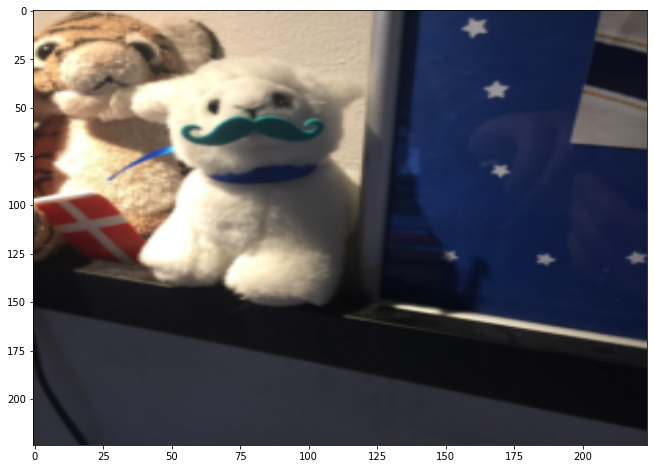



 fake_image index tensor(13)


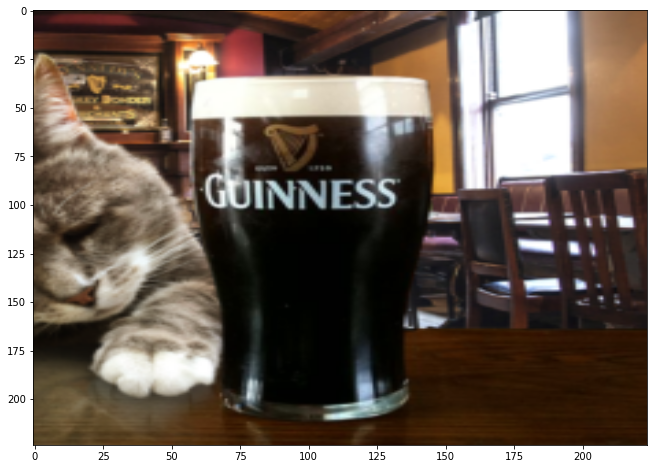

In [6]:
fig = plt.gcf() 
fig.set_size_inches(11,8) # Set width and height for all following figures globally. 
#Note: We need not to resize images, we just need to adjust the figure size as per requirement.

ind=torch.randint(0,15,size=())
show_res = transforms.Resize((1600 ,1600))
print("Real_image index", ind)
plt.imshow(real_images[ind].permute(1,2,0).cpu(),aspect='auto',  interpolation='bilinear')
plt.show()

ind2=torch.randint(0,15,size=())
print("\n\n fake_image index", ind2)
plt.gcf().set_size_inches(11,8) 
plt.imshow(fake_images[ind2].permute(1,2,0).cpu(),aspect='auto',  interpolation='bilinear')
plt.show()

## Define Dataset Class

In [0]:
# This is needed even if we directly load the loaders from saved files.
# We will use this class to create datasets containing image tensors and their labels
def filter_fun(x): #keep it outside.
  return gaussian_filter(x,sigma=1.2 , mode='nearest')

class ImageTensorDataset(Dataset):
  # We do not need transform member since we preprocessed already
  def __init__ (self, image_tensors, labels, augment=False):
    self.image_tensors = image_tensors
    self.labels = labels
    

    self.transform_augment = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((300,300)),
                                                 transforms.RandomHorizontalFlip(p=1),
                                                 transforms.RandomRotation(20),
                                                 transforms.CenterCrop(256),                                                 
                                                 transforms.RandomCrop(224),                                                 
                                                 transforms.Lambda(filter_fun),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=image_mean, std=image_std)])
    self.transform = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=image_mean, std=image_std)])
    self.augment = augment #a flag indicating whether we want or not the augmentation.

  
  # Used to index the dataset [#]
  def __getitem__(self, index):
    if self.augment:
        image_tensor = self.transform_augment(self.image_tensors[index].cpu())#.cuda()
        label = self.labels[index]       
    else: 
        image_tensor = self.transform(self.image_tensors[index].cpu())#.cuda()
        label = self.labels[index]
    return image_tensor, label

  # Used to count how many tensors are in the dataset
  def __len__(self):
    return len(self.image_tensors)

## Separate Data into Training, Validation, & Test

In [10]:
gc.collect()
torch.cuda.empty_cache()
# We only need to give three inputs, rest is done by the function.

# 1. percentage of train,val,test datasize
# 2. dataloader batch_size
# 3. Feature-extracter batch-size known as process_batch (not used here but defined here for clarity.)

ratio = [60,20,20] # These are percentages. Summation must be 100%.
batch_size = 512
process_batch = 32 # Batches of images are passed one-by-one through the feature extractor and at the end all features are concatenated.

num_r= real_images.shape[0]
num_f= fake_images.shape[0]

def partition(ratio, batch_size=batch_size,process_batch=process_batch, \
              num_r=num_r,num_f=num_f,real_images=real_images,real_labels=real_labels,\
              fake_images=fake_images,fake_labels=fake_labels):
  #int acts as a floor() function!
  numtrain_r=int(max(np.ceil(num_r*ratio[0]/100),0))  # Number of real images to use in training dataset
  numtrain_f=int(max(np.ceil(num_f*ratio[0]/100),0))  # Number of fake images to use in training dataset
  numval_r=int(max(np.ceil(num_r*ratio[1]/100),0))    # Number of real images to use in validation dataset
  numval_f=int(max(np.ceil(num_f*ratio[1]/100),0))    # Number of fake images to use in validation dataset
  # rest of the images for the test set.

  X_real= real_images     
  y_real= real_labels     
  X_fake= fake_images
  y_fake= fake_labels     

  X_train=torch.cat((X_real[0:numtrain_r],X_fake[0:numtrain_f]),dim=0)
  y_train=torch.cat((y_real[0:numtrain_r],y_fake[0:numtrain_f]),dim=0).to(torch.long)

  X_val=torch.cat((X_real[numtrain_r:numtrain_r+numval_r],X_fake[numtrain_f:numtrain_f+numval_f]),dim=0)
  y_val=torch.cat((y_real[numtrain_r:numtrain_r+numval_r],y_fake[numtrain_f:numtrain_f+numval_f]),dim=0).to(torch.long)

  X_test=torch.cat((X_real[numtrain_r+numval_r:],X_fake[numtrain_f+numval_f:]),dim=0)
  y_test=torch.cat((y_real[numtrain_r+numval_r:],y_fake[numtrain_f+numval_f:]),dim=0).to(torch.long)
  
  # The following commands to construct dataloaders are fully correct. Refer to DataLoader documentation before making any changes. 
  concat_train_dataset = torch.utils.data.ConcatDataset([ImageTensorDataset(X_train, y_train, False), ImageTensorDataset(X_train, y_train, True)])
  train_loader = DataLoader(concat_train_dataset, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(concat_train_dataset, replacement=False, num_samples=None))   
  val_loader = DataLoader(ImageTensorDataset(X_val, y_val), batch_size=batch_size, sampler=torch.utils.data.RandomSampler(ImageTensorDataset(X_val, y_val), replacement=False, num_samples=None))
  test_loader = DataLoader(ImageTensorDataset(X_test, y_test), batch_size=batch_size, sampler=torch.utils.data.RandomSampler(ImageTensorDataset(X_test, y_test), replacement=False, num_samples=None))

  # Shuffle argument in Dataloader shuffles among multiple batches, but keeps the order within a batch intact!!!!! 
  # We want completely shuffled dataset so we use RandomSampler.
  print("The train, val and test sets contain %d, %d and %d images APPROXIMATELY."%(len(train_loader)*batch_size,len(val_loader)*batch_size,len(test_loader)*batch_size))
  #Approximation due to the last batch containing fewer than batch_size images.

  return train_loader,val_loader,test_loader

train_loader,val_loader,test_loader= partition(ratio)

# Toy dataloader to check model overfitting.
toy_train=torch.cat((toy_real,toy_fake),dim=0) 
toy_train_labels=torch.cat((toy_real_labels,toy_fake_labels),dim=0).to(torch.long)
toy_loader = DataLoader(ImageTensorDataset(toy_train, toy_train_labels), batch_size=batch_size, sampler=torch.utils.data.RandomSampler(ImageTensorDataset(toy_train, toy_train_labels), replacement=False, num_samples=None))

# del real_images Once uncommented, we need to re-download images if we want to recreate loaders!
# del fake_images
# del toy_real
# del toy_fake
gc.collect()
torch.cuda.empty_cache()
print("After augmentation, total number of images are exactly %d "%((num_r+num_f)*(1+ratio[0]/100)))

The train, val and test sets contain 14336, 2560 and 2560 images APPROXIMATELY.
After augmentation, total number of images are exactly 18880 


In [11]:
print(len(train_loader),len(val_loader),len(test_loader))
print("for 5900 real and 5900 fake images, 70% augmentation, summation of total number of images is 20060.")

28 5 5
for 5900 real and 5900 fake images, 70% augmentation, summation of total number of images is 20060.


# Network Setup

## Feature Extractor

In [12]:
#Feature Extractor: It uses pre-trained ResNet-18 as initial layers of our neural network to extract features of the input images.
# Input image size = N x 3 x reshape_size x reshape_size.

class FeatureExtractor(nn.Module):
  """
  Image feature extraction with ResNet-18.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    resnet_original = models.resnet18(pretrained=True)
    self.resnet = nn.Sequential(*list(resnet_original.children())[:-1]) # Use only the first 13 layers [0-12].
   
    self.resnet.cuda()
    if verbose:
      summary(self.resnet.cuda(), (3, reshape_size, reshape_size))
    
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x32x32
    
    Outputs:
    - feat: Image feature, of shape Nx___ (pooled) or Nx____x houtx wout
    """
    num_img = img.shape[0]
    img_prepro = img.to(device=global_device,dtype=global_dtype)

    feat = []
    for b in range(math.ceil(num_img/process_batch)):   

      feat.append(self.resnet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat.to(device=global_device,dtype=global_dtype)

feat_extr = FeatureExtractor(verbose=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64

## Image Classifier

In [13]:
# This is our network which we will train. Input to this network would be extracted features of the images through the FeatureExtractor.
""" NOTE: Since feature_extractor is defined in init() below, algorithm will re-train it!! 
    
"""
class Image_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.feat_extr = FeatureExtractor(reshape_size=image_resize)
    self.fl= nn.Flatten()
    self.fc1 = nn.Linear(512,128)
    self.relu1=nn.LeakyReLU(negative_slope=0.01)
    self.dropout1 = nn.Dropout(p=0.7)
    self.fc2 = nn.Linear(128,1) # maps to final 1 output score to be used in
                                # predicting real or fake image.
  
  def forward(self, x):  # forward always defines connectivity
    self.cuda()
    local_dtype=x.dtype
    local_device=x.device
    
    # Image feature extraction
    features=self.feat_extr(x).squeeze()  
    out1=self.fc2(self.dropout1(self.relu1(self.fc1(features))))
    scores=(out1).squeeze()
    
    return scores

gc.collect()
torch.cuda.empty_cache()
im_cls=Image_classifier()
summary(im_cls, (3, image_resize, image_resize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Setting-up the Training Process

In [0]:
class Assembly(): 
  """
  Processing assembly-line that defines how the model training/ testing commands 
  will be executed.
  """
  ### Calculate Accuracy: Validation/ Testing Commands
  def check_accuracy(self,loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for  t, (x, y) in enumerate(loader):
            x = x.to(device='cuda', dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device='cuda', dtype=torch.long)        
            
            preds = torch.round(torch.sigmoid(model(x))).to(dtype=torch.long)
            num_correct += (preds == y).sum()
            num_samples += preds.shape[0]

        acc = 100*float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, acc))
        
    return acc  

  def adjust_learning_rate(self,optimizer, lr_decay, epoch, schedule):
    """
    Multiply lr_decay to the learning rate if epoch is in schedule
  
    Inputs:
    - optimizer: An Optimizer object we will use to train the model
    - lr_decay: learning rate decay; can be a list or just a single number.
      a factor multiplied with present learning rate at scheduled epochs (fpor example, 0.95*learning_rate)
    - epochs: the current epoch number
    - schedule: the list of epochs that requires learning rate update
  
    Returns: Nothing, but learning rate might be updated
    """
    schedule=sorted(schedule) #sort the lr_schedule.

    if epoch in schedule:
      for param_group in optimizer.param_groups:
        if type(lr_decay) is list:
          if len(lr_decay)>=schedule.index(epoch)+1: # if length of lr_decay list is greater than or equal to length of the lr_schedule
            decay_factor=lr_decay[schedule.index(epoch)]
          else:
            decay_factor=lr_decay[-1] #the last decay_factor available in the lr_decay list.
        else:
          decay_factor=lr_decay #If not a list.        
        
        print('                                            \
        lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * decay_factor)) #printed before updating.
        param_group['lr'] *= decay_factor


  def model_run(self,model, loader, optimizer, train_flag=False, v_loader=val_loader, \
                epochs=1, lr_scheduler='manual',lr_schedule=[],lr_decay=.95, num_patience=1, \
                verbose=True):
    """
    Train a model on dataset using the PyTorch Module API.
  
    Inputs:
    - model: A PyTorch module giving the model to train.
    - loader: Train-loader or Test-loader
    - v_loader: Loader to check validation accuracy against, during training. 
                Default = default validation loader. Only changes during toy-training.
                Ignored during testing.
    - optimizer: An Optimizer object we will use to train the model
    - train_flag: should be set to 'True' while training, default='False'.
    - epochs: (Optional) A Python integer giving the number of epochs to train for.
              Testing only runs for 1 epoch, value of epochs is disregarded. 
    - lr_scheduler== 'manual': uses self.adjust_learning_rate() function to decay
                               the learning rate by multiplying it with 'lr_decay' value for 
                               epochs scheduled in 'lr_schedule' list.
    - lr_decay: value (can be a list in 'manual' mode) multiplied with existing learning rate to decrease it.                           
    - lr_schedule: list of epochs when learning rate is reduced. ex. [8,16].

    - lr_scheduler=='auto': uses optim.lr_scheduler.ReduceLROnPlateau() to automatically
                            reduce the learning rate by multiplying it with 'lr_decay' when 
                            it starts plateauing, after waiting for 'num_patience' epochs.
    - num_patience: number of epochs to wait for before reducing the learning rate.

    See that lr_decay is used with both types of lr_scheduler but its value may be drastically
    different for both based on when they reduce the learning rate.
    Example case: 
    lr_scheduler= 'manual', lr_decay=0.9 
    lr_scheduler= 'auto', lr_decay=0.1.
    Further, lr_decay can be a list in 'manual' mode, as we might want to apply different decay at different epochs.

    Output(s): 
    if train_flag==1:
      acc_history, iter_history,loss_list
    else:
      acc_history: just one test-accuracy value.
    """
  
    if train_flag==True:
      model.train()  # put model to training mode
    else:
      model.eval()   # put model to testing mode.
   
    loss_list=[]
    print_every = 10  #print accuracy at every x number of iterations.
    model = model.to(device=global_device)  # move the model parameters to CPU/GPU
    num_iters = epochs * len(loader)
  
    if verbose:
      num_prints = num_iters // print_every + 1
    else:
      num_prints = epochs
  
    acc_history = torch.zeros(num_prints, dtype=global_dtype, device=global_device)
    iter_history = torch.zeros(num_prints, dtype=torch.long, device=global_device)
  

    if train_flag==True: #Training: Multiple Epochs. (Testing -> only one epoch.)
      
      best_acc = 0.0 
                                         
      if lr_scheduler == 'auto':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', lr_decay, num_patience, verbose)

      for e in new_tqdm(range(epochs)):
        if lr_scheduler == 'manual':
          self.adjust_learning_rate(optimizer, lr_decay, e, lr_schedule)
    
        for t, (x, y) in enumerate(loader):   
          x=x.cuda()
          y=y.cuda()
          scores=model(x).squeeze() 
          preds=scores
    
          loss=F.binary_cross_entropy_with_logits(preds.to(dtype=global_dtype), y.to(dtype=global_dtype))
          loss_list.append(loss)

          tt = t + e * len(loader)
          print("loss: ", loss.item(), "Epoch: ", e, "Iteration: ", tt)

          # Zero out all of the gradients before running the back-propagation, so that 
          # only gradients computed afresh are considered.
          optimizer.zero_grad()

          # This is the backwards pass: compute the gradient of the loss with
          # respect to each  parameter of the model.
          loss.backward()

          # Update the parameters of the model using the gradients
          # computed by the backwards pass.
          optimizer.step()      
          
          if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader)-1)):
            acc = self.check_accuracy(v_loader, model)
            print("Validation Accuracy: ",acc)
            acc_history[tt // print_every] = acc
            iter_history[tt // print_every] = tt
            if acc > best_acc:
              best_acc = acc
              best_model_wts = copy.deepcopy(model.state_dict())  
        
          elif not verbose and (t == len(loader)-1):
            acc = self.check_accuracy(v_loader, model)
            print("Validation Accuracy: ",acc)
            acc_history[e] = acc
            iter_history[e] = tt
            if acc > best_acc:
                best_acc = acc
                best_model_wts = copy.deepcopy(model.state_dict())        
        
        if lr_scheduler == 'auto':
          scheduler.step(loss)


      if acc_history[-1]==0:
        if len(acc_history) == len(iter_history):
          iter_history = iter_history[:-1]
        acc_history=acc_history[:-1]

      
    else: #Inference (testing)
        acc_history = torch.tensor(self.check_accuracy(loader, model), dtype=global_dtype, device=global_device) #just one value.
        print("Accuracy: ",acc_history) #acc_history has been cast to torch.tensor() to have consistency with training case.

    if train_flag==True:
      model.load_state_dict(best_model_wts)
      best_model=model
      best_params=copy.deepcopy(optimizer.state_dict())       
      return acc_history, iter_history,loss_list,best_model,best_params
      
    else:
      return acc_history

#**Model Training Guidelines:**
##Here are some guidelines for training this model:
1. Model training will take long time, be patient. Generally, longer training
   produces better results.
   longer= no less than 6 epochs, maybe as many as 30 epochs.
2. Batch_size of at least 256 is required for the model to learn, this has been 
   verified through multiple experiments.
3. When you first time run the model, it will show CuDA memory outage, consider 
   that as warmup exercise. Without reducing the batch size or changing 
   anything, simply restart the runtime and run all from the menu bar at the 
   top of the notebook. Do NOT reconnect with the GPU from top-right, that is 
   essentially the same as starting from stage 0. You will know the difference 
   between these two tasks within a few trials. Simply put, do as little as you 
   can to ‘restart and run all the blocks’.
4. Keep the learning rate low, momentum less and training time large. Keep 
   reasonable regularization to ensure that the model learns something out of 
   the train-set.

```
learning_rate = 0.0025         
reg = 0.003                # coefficient in front of ||W||^2 (= lambda of L2 regularization term.)
momentum = 0.85             # only used in Stochastic Gradient Descent Optimizer.
# Model hyperparameters
train_epochs=3
lr_schedule=[1,2,3, 6, 11, 15, 19,21,23,25,27]
lr_decay=   [.95,.95,.8, .9, 0.7,0.5] # list will be followed until exhausted, and then the last factor will be kept as the constant decay_factor.
```


#**Training the Model on Full Training Dataset:**
## Training Mode-1: 'Manual'
- We perform Manual Learning Rate Scheduling

In [0]:
# #load the best parameters found so far.
# best_params=torch.load("/content/drive/Shared drives/EECS504/Trained_Models/Augmented_params_BN_CLS_batch_512_train_val76.9915_test_63.3475.pt")
# print(best_params)

[{'lr': 0.0011371500000000002, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0.005, 'nesterov': False, 'params': [140321431729280, 140323537960032, 140327404557872, 140323764706832, 140323764706328, 140323764706544, 140323764705608, 140323764705968, 140323764703304, 140323764703520, 140323764704816, 140323764704600, 140323764704456, 140323764703880, 140323764704888, 140323764707120, 140323764706184, 140323764705824, 140323764705464, 140323540192208, 140323540190048, 140323764704744, 140323764704168, 140323764703952, 140323540190696, 140323540192856, 140323540191992, 140323540191704, 140323540192784, 140323540192568, 140323540192280, 140323540191272, 140323540191488, 140323540190552, 140323540189544, 140323540190624, 140323540189832, 140323540192064, 140323540191848, 140323540190192, 140323908691072, 140323908690136, 140323908692080, 140323908691360, 140323908690424, 140323908693664, 140323908692872, 140323908693160, 140323908692944, 140323908690640, 140323908691144, 140323908691792,

loss:  0.6952865123748779 Epoch:  0 Iteration:  0
Got 1186 / 2360 correct (50.25)
Validation Accuracy:  50.25423728813559
loss:  0.6925585269927979 Epoch:  0 Iteration:  1
loss:  0.7055870294570923 Epoch:  0 Iteration:  2
loss:  0.6959395408630371 Epoch:  0 Iteration:  3
loss:  0.6945112347602844 Epoch:  0 Iteration:  4
loss:  0.6904257535934448 Epoch:  0 Iteration:  5
loss:  0.6889481544494629 Epoch:  0 Iteration:  6
loss:  0.6916680335998535 Epoch:  0 Iteration:  7
loss:  0.6886372566223145 Epoch:  0 Iteration:  8
loss:  0.6837130784988403 Epoch:  0 Iteration:  9
loss:  0.6762143969535828 Epoch:  0 Iteration:  10
Got 1452 / 2360 correct (61.53)
Validation Accuracy:  61.52542372881356
loss:  0.6790097951889038 Epoch:  0 Iteration:  11
loss:  0.6841097474098206 Epoch:  0 Iteration:  12
loss:  0.6798949241638184 Epoch:  0 Iteration:  13
loss:  0.6840605735778809 Epoch:  0 Iteration:  14
loss:  0.6830583810806274 Epoch:  0 Iteration:  15
loss:  0.6749709844589233 Epoch:  0 Iteration:  16

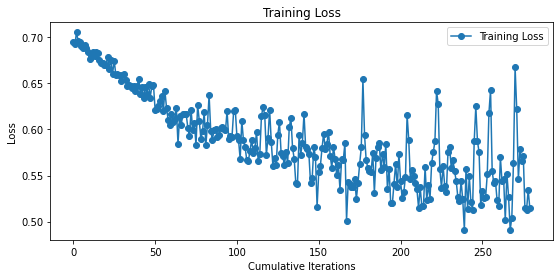

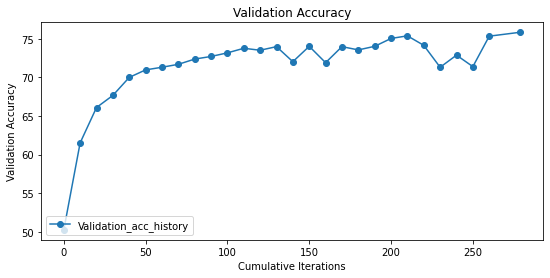

tensor([50.2542, 61.5254, 66.1017, 67.6695, 70.0000, 70.9746, 71.3136, 71.6949,
        72.3729, 72.7119, 73.1780, 73.7712, 73.5170, 73.9830, 72.0339, 74.0254,
        71.9068, 73.9830, 73.5593, 74.0254, 75.0424, 75.3814, 74.1525, 71.3136,
        72.8814, 71.3983, 75.3390, 75.8475], device='cuda:0')


In [19]:
"""
Training Commands. Hyperparameters can be tuned for performance. \
Do not forget to save the trained model by uncommenting the next cell.
"""
# Protect from CUDA memory leaks if you interrupt execution
# if model:
#   del model
# if assembly:
#   del assembly

gc.collect()
torch.cuda.empty_cache()

assembly=Assembly()
# Be patient while training the model, it is a large model. 
# Training will take some time, stay tuned.

# Optimizer hyperparameters 
learning_rate = 0.01         
reg = 0.01                # coefficient in front of ||W||^2 (= lambda of L2 regularization term.)
momentum = 0.3             # only used in Stochastic Gradient Descent Optimizer.
# Model hyperparameters
train_epochs=10
lr_schedule=[1,2,3, 6, 11, 15, 19,21,23,25,27]
lr_decay=   [0.9,0.7,.95,.95,.8, .9, 0.7,0.5]

torch.autograd.set_detect_anomaly(True) #enabled anomaly detection to find the operation that failed to compute its gradient

model = Image_classifier().to(device=global_device, dtype=global_dtype)

# optimizer = optim.Adam( model.parameters(), lr=0.0001, weight_decay=0.01)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg,momentum=momentum,nesterov=False )

acc_history,iter_history, loss_list,best_model,best_params = assembly.model_run(model, train_loader, optimizer, train_flag=True, \
                                                v_loader=val_loader, epochs=train_epochs,lr_scheduler='manual',lr_schedule=lr_schedule,lr_decay=lr_decay)

# plot the Training Loss vs. iterations
plt.plot(loss_list, '-o')
plt.legend(['Training Loss'], loc='upper right')
plt.xlabel('Cumulative Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

# plot the Validation Accuracy vs. iterations
plt.plot(list(iter_history),list(acc_history), '-o')
plt.legend(['Validation_acc_history'], loc='lower left')
plt.xlabel('Cumulative Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()
print(acc_history)


#Inference Results for Training mode = 'Manual':

In [0]:
test_acc = assembly.model_run(best_model, test_loader, optimizer, train_flag=False,epochs=1)
val_acc = assembly.model_run(best_model, val_loader, optimizer, train_flag=False,epochs=1)

Got 1490 / 2360 correct (63.14)
Accuracy:  tensor(63.1356, device='cuda:0')
Got 1790 / 2360 correct (75.85)
Accuracy:  tensor(75.8475, device='cuda:0')


#**Saving the trained model:**
###Instructions:
The following command, when uncommented, will save the above trained model to Google Drive in a secured place such that this trained model can be accessed by this and any other notebooks.

**1. Uncomment the following cell and run it.**   
**2. Comment it back to remove the possiblity of accidental overwriting.**


In [0]:
# model_save_name1 = f"Augmented_BN_CLS_batch_{batch_size}_train_val{val_acc:.6}_test_{test_acc:.6}.pt"
# path = F"/content/drive/Shared drives/EECS504/Trained_Models/{model_save_name1}" 
# torch.save(best_model.state_dict(), path)

# params_save_name = f"Augmented_params_BN_CLS_batch_{batch_size}_train_val{val_acc:.6}_test_{test_acc:.6}.pt"
# path2 = F"/content/drive/Shared drives/EECS504/Trained_Models/{params_save_name}" 
# torch.save(best_params['param_groups'],path2)

# acc_name=f"Augmented_BN_CLS_Acc_history_batch_{batch_size}_train_val{val_acc:.6}_test_{test_acc:.6}.pt"
# path = F"/content/drive/Shared drives/EECS504/Trained_Models/{acc_name}" 
# torch.save(acc_history, path)